In [128]:
import boto3
import sagemaker

#visualize
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn')
import seaborn as sns

import pandas as pd
import numpy as np

import os
import pickle

In [103]:
!pip install --upgrade pip
!pip install -q imbalanced-learn

In [129]:
# Sagemaker activation
session = boto3.session.Session()
region_name = session.region_name
print(f'region name: {region_name}')
sagemaker_session = sagemaker.Session()
bucket = 'klarnadataset'
role = sagemaker.get_execution_role()

region name: us-east-2


In [131]:
# save model in S3
def upload_to_S3(pkl_filename,model):
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    s3_resource = boto3.resource('s3')
    pickle_byte_obj = pickle.dumps(model)
    s3_resource.Object(bucket,pkl_filename).put(Body=pickle_byte_obj)

In [132]:
# load dat from s3
prefix = 'data_prep'
data_key_df = 'df_1_to_2.csv'
data_location = 's3://{}/{}/{}'.format(bucket, prefix, data_key_df)
df = pd.read_csv(data_location,delimiter=',',index_col=0)

In [76]:
df.head(5)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_status,age,avg_payment_span_0_12m,avg_payment_span_0_3m,...,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv,worst_status
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,1.0,20,12.692308,8.333333,...,1,1,1,0,0,0,178839,9.653333,1.000000,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,1.0,50,25.833333,25.000000,...,1,2,2,0,0,0,49014,13.181389,1.202723,1.0
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,1.0,22,20.000000,18.000000,...,1,2,2,0,0,0,124839,11.561944,1.000000,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,0.0,0.0,0.0,1.0,36,4.687500,4.888889,...,1,1,1,0,0,0,324676,15.751111,1.000000,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,1.0,25,13.000000,13.000000,...,1,1,1,0,0,0,7100,12.698611,1.067889,1.0


## 0) Drop: uuid

In [133]:
df.drop(columns=['uuid'],inplace=True)

## 1) Convert merchant_group to dummy variables

In [135]:
df = pd.get_dummies(df, columns=["merchant_group"], prefix=["merchant_group"] )

In [108]:
df.head(5)

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_status,age,avg_payment_span_0_12m,avg_payment_span_0_3m,has_paid,...,merchant_group_Clothing & Shoes,merchant_group_Electronics,merchant_group_Entertainment,merchant_group_Erotic Materials,merchant_group_Food & Beverage,merchant_group_Health & Beauty,merchant_group_Home & Garden,merchant_group_Intangible products,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby"
0,0.0,0,0.0,0.0,0.0,1.0,20,12.692308,8.333333,True,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0,0.0,0.0,0.0,1.0,50,25.833333,25.000000,True,...,0,0,1,0,0,0,0,0,0,0
2,0.0,0,0.0,0.0,0.0,1.0,22,20.000000,18.000000,True,...,0,0,1,0,0,0,0,0,0,0
3,0.0,0,0.0,0.0,0.0,1.0,36,4.687500,4.888889,True,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0,0.0,0.0,0.0,1.0,25,13.000000,13.000000,True,...,0,1,0,0,0,0,0,0,0,0


## 2) Convert name_in_email to a categorical variable:
#### reveals personal info or not

In [136]:
df['name_in_email'].value_counts()

F+L         40389
no_match    16826
L1+F        16089
F            9705
Nick         8310
F1+L         7300
L            1332
Initials       25
Name: name_in_email, dtype: int64

In [137]:
def email_address_format(x):
    if x in ['no_match','Nick']:
        x = 0 # doesn't reveal personal information
    elif x in ['F+L','L1+F','F','F1+L','L','Initials']:
        x = 1 # provides personal information
    else:
        pass
    return x

In [138]:
df['name_in_email'] = df['name_in_email'].apply(lambda x: email_address_format(x))

## 3) Convert has_paid from boolean to categorical 

In [139]:
df['has_paid'] = df['has_paid'].apply(lambda x: 0. if x == True else 1.)

## 4) Normalize the whole dataset

#### For a tree-based algortihm the normalization process would not be necessary. However, to oversample the minority class a KNN-based algoritm is used below, which performs better on normalized data

In [140]:
from sklearn.preprocessing import RobustScaler # better in the presence of outliers than MinMaxScaler

In [141]:
# Split data train test

In [142]:
train, test = df.dropna(), df[df.isnull().any(axis=1)]

In [143]:
scaler = RobustScaler().fit(train)

In [144]:
train_norm = scaler.transform(train)
test_norm = scaler.transform(test)

In [145]:
upload_to_S3('robust_scaler.pkl',scaler)

In [146]:
train_norm = pd.DataFrame(train_norm,columns=train.columns)
train_norm.head(5)

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_status,age,avg_payment_span_0_12m,avg_payment_span_0_3m,has_paid,...,merchant_group_Clothing & Shoes,merchant_group_Electronics,merchant_group_Entertainment,merchant_group_Erotic Materials,merchant_group_Food & Beverage,merchant_group_Health & Beauty,merchant_group_Home & Garden,merchant_group_Intangible products,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby"
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.70,-0.009059,-0.279070,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.80,0.949521,0.883721,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,-0.60,0.524005,0.395349,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.10,-0.592975,-0.519380,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.45,0.013386,0.046512,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5) Class Imbalance Strategy: over and undersampling

#### In order to balance the target examples, the minority class is oversampled using SMOTE, and the majority class is undersampled. To avoid introducing even more bias in the oversamplimg, the final target ratio is not forzed to be 1:1 

array([88688,  1288])

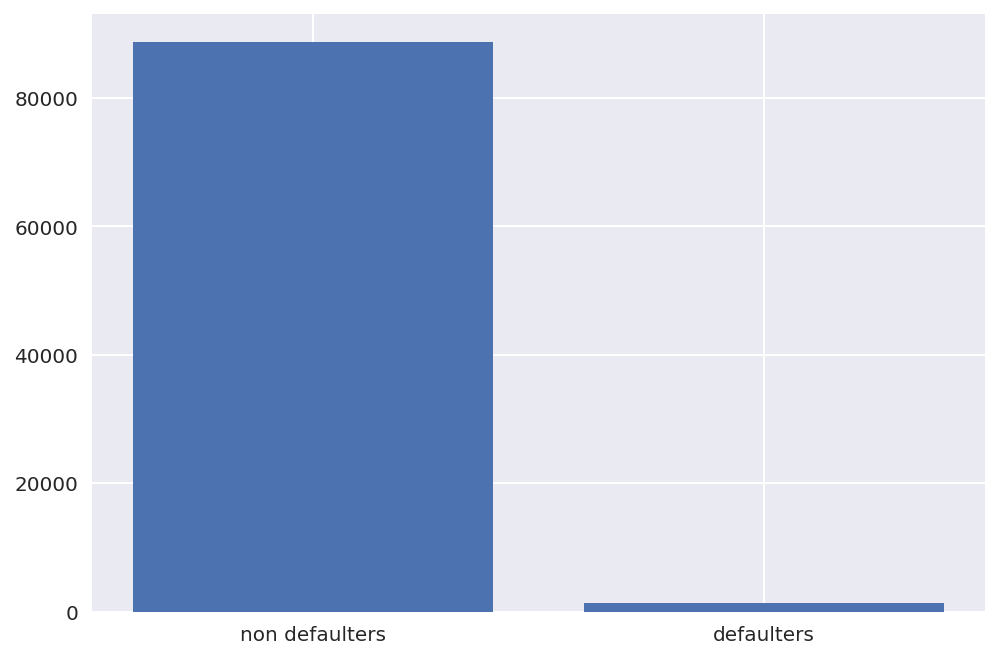

In [89]:
plt.bar(['non defaulters','defaulters'],train_norm['default'].value_counts().values)
train_norm['default'].value_counts().values

## 5a) Undersampling

In [90]:
train_norm_no_defaulters = train_norm[train_norm['default'] == 0.]

# 40% of the majority class examples are dropped
train_norm__no_defaulter_under = train_norm_no_defaulters.sample(frac=0.6, random_state=42)

In [91]:
# merge undersampled training set with the majority class examples
train_under = pd.concat([train_norm__no_defaulter_under,train_norm[train_norm['default'] == 1.]])
train_under['default'].value_counts()

0.0    53213
1.0     1288
Name: default, dtype: int64

## Create a validation set

In [92]:
# 80% train, 20% val
# Only the training set is oversampled
train_under_,val_under_ = np.split(pd.DataFrame(train_under).sample(frac=1, random_state=42), 
                       [int(.8*len(train_under))])

## 5b) Oversampling

In [93]:
from imblearn.over_sampling import SMOTE

In [94]:
train_under_['default'].value_counts()

0.0    42577
1.0     1023
Name: default, dtype: int64

In [95]:
# oversampling the training set
smote = SMOTE(sampling_strategy=0.6,k_neighbors=5)
X_train_under_over, y_train_under_over = smote.fit_resample(train_under_.drop(columns=['default']), 
                                                            train_under_['default']
                                                           )


0.0    42577
1.0    25546
Name: default, dtype: int64

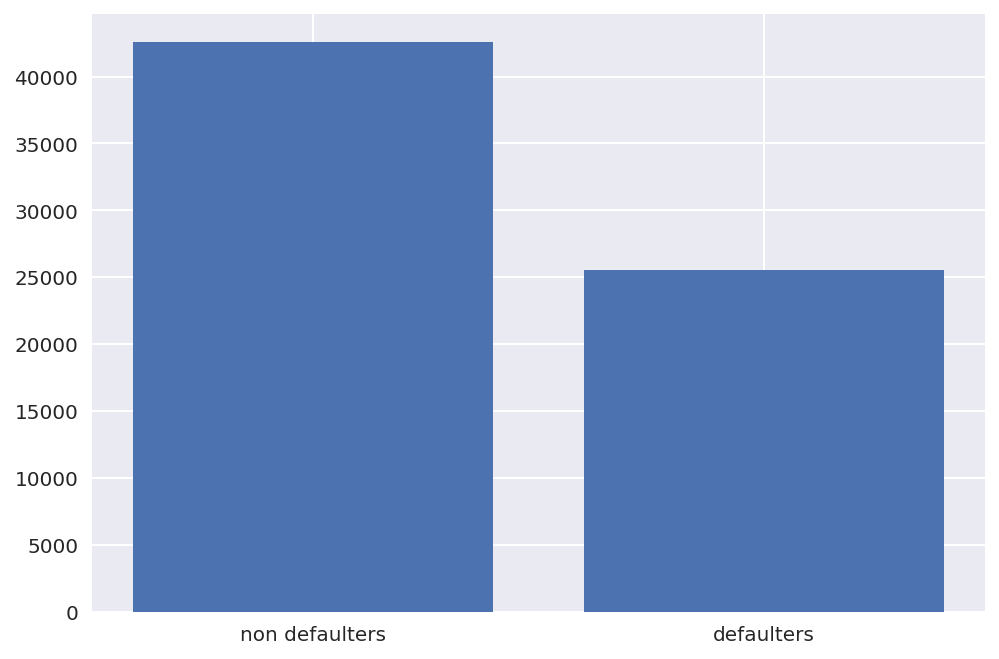

In [96]:
plt.bar(['non defaulters','defaulters'],y_train_under_over.value_counts().values)
y_train_under_over.value_counts()

In [97]:
# put X and y-labels together
X_train_under_over.insert(0, 'default', y_train_under_over)

In [98]:
# shuffle the dataset
train_model = X_train_under_over.sample(frac=1,random_state=42)

In [99]:
val_model = val_under_
test_model = pd.DataFrame(test_norm,columns=train_model.columns).drop(columns=['default'])

In [100]:
train_model.to_csv('train_columns.csv', index=False, header=True)
#train_model.to_csv('train.csv', index=False, header=False)
#val_model.to_csv('val.csv', index=False, header=False)
#test_model.to_csv('test.csv', index=False, header=False)

In [101]:
prefix= 'modeling'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train_columns.csv')).upload_file('train_columns.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val.csv')).upload_file('val.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test.csv')).upload_file('test.csv')